In [ ]:
%matplotlib inline
    
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import os
from PIL import Image, ImageEnhance

def load_images(path):
    images = []
    for i in os.listdir(path):
        img_path = os.path.join(path, i)
        images.append(Image.open(img_path))
    return images

# Explore the Data

In [4]:
english_dataset = np.array(pd.read_csv('/A_Z Handwritten Data.csv'))

english_alphabet = pd.DataFrame(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                                 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                                'u', 'v', 'w', 'x', 'y', 'z'], [i for i in range(1, 27)])
english_alphabet.head()

,0
1,a
2,b
3,c
4,d
5,e


In [6]:
X, y = english_dataset[:, 1:], english_dataset[:, 0]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.shape, y.shape

((372450, 784), (372450,))

**Visualizing data**

In [8]:
def plot_letters(images, labels, width=14, height=14):
    rows, cols = 4, 6

    fig=plt.figure(figsize=(14, 14))
    sub_plot_i = 1

    for i in range(0, 20):
        fig.add_subplot(rows, cols, sub_plot_i)
        sub_plot_i += 1
        image = images[i].reshape(width, height)
        plt.imshow(image, cmap='gray')
        label = labels[i].astype(int) + 1
        plt.title(english_alphabet.loc[label][0])


    fig.tight_layout()    
    plt.show()

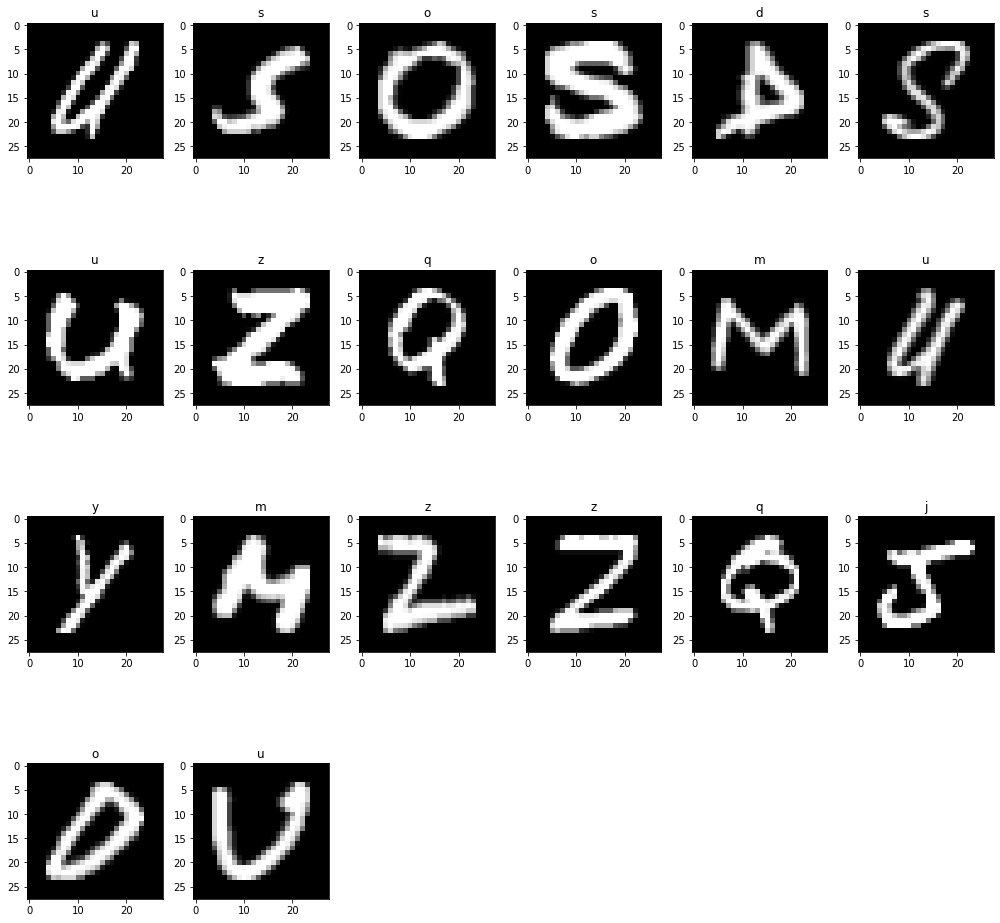

In [9]:
plot_letters(X_train, y_train, 28, 28)

# Prepare the Data

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, width=14, height=14,  is_img=False):
        self.width = width
        self.height = height
        self.is_img = is_img
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_img:
            images = []
            # load the image and convert to grayscale
            for img in X:                
                
                image = img.convert('L').resize((self.width, self.height))
                
                enhancer = ImageEnhance.Contrast(image)
                image = enhancer.enhance(1.0)
                
                images.append(np.asarray(image).reshape(-1))
            return np.array(images)
        else:
            return X

In [11]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


preprocessing_pipeline = Pipeline([
    ('image_trf', ImageTransformer()),
    ('scaler', StandardScaler()),
])

width, height = 28, 28
preprocessing_pipeline.set_params(image_trf__width=width, image_trf__height=height, image_trf__is_img=False)
X_train_proc = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

# Train Model

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [12]:
import itertools

def display_conf_mat(model, X, y):
    _, ax = plt.subplots(figsize=(20, 20))
    plot_confusion_matrix(model, X, y, 
                          display_labels=np.array(english_alphabet[0]).astype(str),
                          cmap=plt.cm.Blues, ax=ax)
    plt.show()
    

def custom_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**Convolutional Neural Network**

In [13]:
# Reshape for CNN
from sklearn.preprocessing import OneHotEncoder

X_train_proc_cnn = X_train_proc.reshape((-1, 28, 28, 1))
y_train_proc_cnn = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

X_test_cnn = X_test.reshape((-1, 28, 28, 1))

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

l2 = 0.001
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=((28, 28, 1))))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (1, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2)))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          4160      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train_proc_cnn, y_train_proc_cnn, batch_size=256, epochs=5)

Epoch 1/5
1164/1164 [==============================] - 9s 5ms/step - loss: 0.7262 - accuracy: 0.8481
Epoch 2/5
1164/1164 [==============================] - 6s 5ms/step - loss: 0.2018 - accuracy: 0.9735
Epoch 3/5
1164/1164 [==============================] - 6s 5ms/step - loss: 0.1648 - accuracy: 0.9768
Epoch 4/5
1164/1164 [==============================] - 6s 5ms/step - loss: 0.1425 - accuracy: 0.9791
Epoch 5/5
1164/1164 [==============================] - 6s 5ms/step - loss: 0.1328 - accuracy: 0.9802


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

predictions = model.predict(X_test_cnn)
y_pred_cnn = tf.argmax(predictions, axis=1)
y_pred_cnn = np.array(y_pred_cnn)
accuracy_score(y_pred_cnn, y_test)

0.9811384078399785

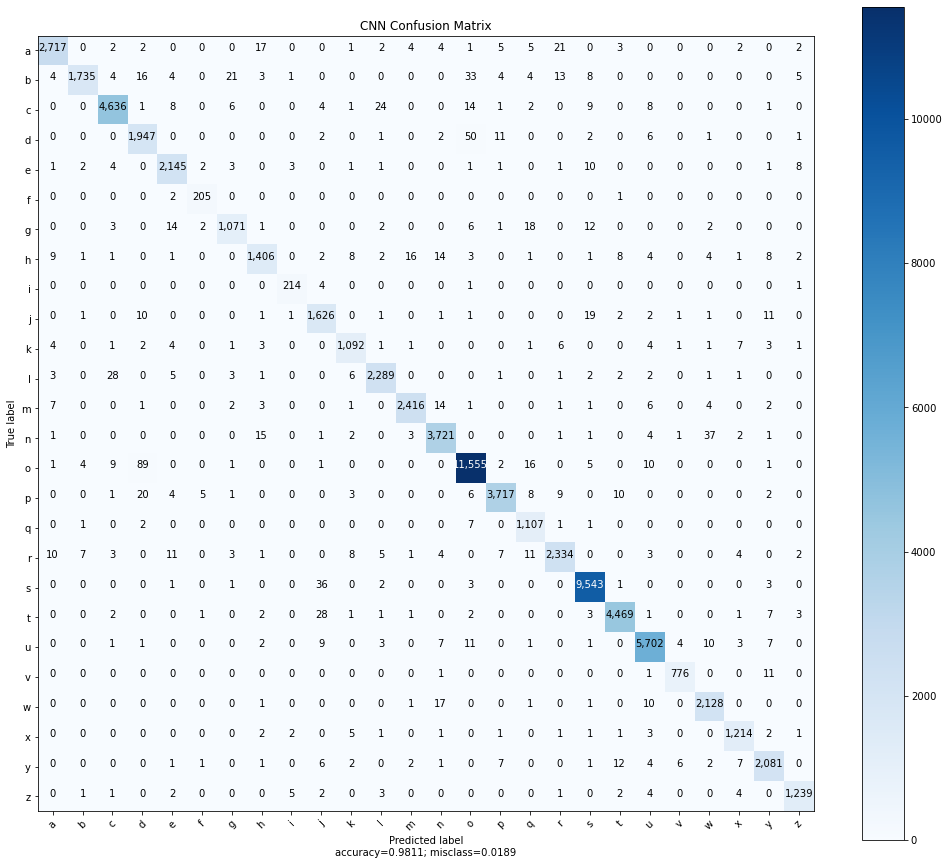

In [17]:
conf_mx = confusion_matrix(y_pred_cnn, y_test)
custom_confusion_matrix(cm=conf_mx, normalize=False,
                        target_names=np.array(english_alphabet[0]).astype(str),
                        title= "CNN Confusion Matrix")

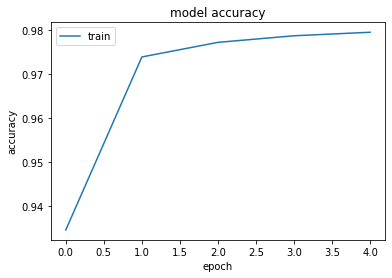

In [18]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Conclusions

The model is providing 97% accuracy, over the target 95% accuracy. This indicates the model is OVERFIT.

# Prediction

In [19]:
def predict_letters(images, width=14, height=14, alphabet=None, model=None):
    rows, cols = 1, len(images)

    fig=plt.figure(figsize=(width, height))
    sub_plot_i = 1

    for i in range(0, len(images)):
        fig.add_subplot(rows, cols, sub_plot_i)
        sub_plot_i += 1
        image = images[i]
        plt.imshow(image, cmap='gray')
    fig.tight_layout()    
    plt.show()
    
    
    #model.predict is where we predict using the test data with a trained NN Model
    predictions = tf.argmax(model.predict(images), axis=1).numpy() + 1
    predictions = [alphabet.loc[p][0] for p in predictions]
    
    return predictions

In [20]:
def look_for_characters(chars, alphabet=None):
    char_idx = [alphabet[alphabet[0] == p].index[0] for p in chars]
    return [list(y_test).index(c - 1) for c in char_idx]

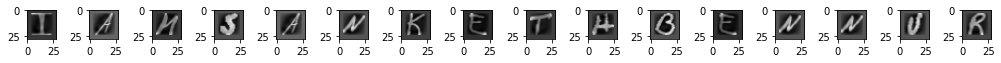

['i', 'a', 'm', 's', 'a', 'n', 'k', 'e', 't', 'h', 'b', 'e', 'n', 'n', 'u', 'r']


In [22]:
to_read = ['i','a','m','s','a','n','k','e','t','h','b','e','n','n','u','r']

read_chars = look_for_characters(to_read, english_alphabet)
pred_read = predict_letters(X_test_cnn[read_chars], width=14, height=14, alphabet=english_alphabet, model=model)
print(pred_read)

### Utilizing Google Text-to-Speech to read the characters aloud.

In [ ]:
!pip install gTTS

In [ ]:
from gtts import gTTS
import os
  
# The text that you want to convert to audio
# mytext = 'Welcome to the new world'
mytext = ''.join(pred_read)
  
# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
# here we have marked slow=False. Which tells 
# the module that the converted audio should 
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
# welcome 
myobj.save("./welcome.mp3")

# Playing the converted file
os.system("mpg321 ./welcome.mp3")

In [ ]:
from pydub import AudioSegment
import IPython

path = './welcome.mp3'

IPython.display.Audio(path)